In [1]:
import mne
import os
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay

# Directory paths
edf_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your EDF files
annotation_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'  # Replace with the actual path to your annotation files

# Initialize lists to store features and labels
all_wavelet_features = []
all_labels = []

# Define the wavelet transform function
def compute_wavelet_features(data, wavelet='db4', level=4):
    coeffs = pywt.wavedec(data, wavelet, level=level)
    # Extract statistics from each wavelet level (mean, std deviation)
    features = [np.mean(c) for c in coeffs] + [np.std(c) for c in coeffs]
    return features

# Iterate over each EDF and annotation file pair
for i in range(1, 155):  # Adjust range for files from SN001 to SN154
    if i == 138:
        continue  # Skip SN138
    
    # Format the index to include leading zeros
    file_index = f'{i:03}'  # Ensures the file index has three digits, e.g., 001, 002, ..., 154
    edf_file = os.path.join(edf_dir, f'SN{file_index}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_index}_sleepscoring.txt')


    
    # Load EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)  # Crop 150s from start and end
    raw.filter(0.5, 30, fir_design='firwin')  # Bandpass filter
    raw.resample(100)  # Resample

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    
    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) &
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150
    
    # Set annotations
    annotations = mne.Annotations(
        onset=filtered_annotations_df['Recording onset'].values,
        duration=filtered_annotations_df['Duration'].values,
        description=filtered_annotations_df['Annotation'].values
    )
    raw.set_annotations(annotations)
    
    # Create events and epochs
    events, event_id = mne.events_from_annotations(raw)
    epochs = mne.Epochs(raw, events, event_id, tmin=0, tmax=30, baseline=None, preload=True)
    
    # Encode labels
    labels = epochs.events[:, -1]
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    
    # Wavelet feature extraction
    eeg_data = epochs.get_data()  # Shape: (n_epochs, n_channels, n_timepoints)
    wavelet_features = []
    for epoch in eeg_data:
        for channel_data in epoch:
            features = compute_wavelet_features(channel_data)
            wavelet_features.append(features)
    wavelet_features = np.array(wavelet_features)
    wavelet_features = wavelet_features.reshape(len(labels), -1)  # Reshape for ML input

    # Append to the main lists
    all_wavelet_features.extend(wavelet_features)
    all_labels.extend(labels)

# Save preprocessed data for reuse
np.save('wavelet_features.npy', all_wavelet_features)
np.save('wavelet_labels.npy', all_labels)
print("Data saved successfully.")


Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
832 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 832 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
930 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 930 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
992 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 992 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
935 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 935 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1010 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1010 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
877 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 877 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
900 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 900 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1117 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1117 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
913 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 913 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
980 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 980 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
700 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 700 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
843 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 843 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1064 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1064 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1090 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1090 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
924 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 924 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
932 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 932 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
978 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 978 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
767 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 767 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
966 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 966 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
859 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 859 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
848 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 848 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
927 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 927 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1032 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1032 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
749 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 749 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1164 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1164 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
498 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 498 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep S

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
784 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 784 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
806 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 806 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
903 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 903 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
863 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 863 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
813 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 813 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1126 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1126 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
990 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 990 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
947 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 947 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
691 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 691 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
687 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 687 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
860 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 860 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1232 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
777 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 777 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
908 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 908 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
905 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 905 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
987 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 987 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
916 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 916 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
474 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 474 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1129 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1129 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
752 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 752 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1025 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1025 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
802 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 802 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R')]
Not setting metadata
446 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 446 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep 

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1216 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1216 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
706 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 706 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1015 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1015 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
986 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 986 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
942 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 942 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
817 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 817 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
713 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 713 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
648 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 648 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1066 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1066 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1034 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1034 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 867 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1065 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1065 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
663 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 663 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
830 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 830 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
850 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 850 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1093 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1093 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
865 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 865 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1124 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1124 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
721 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 721 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1063 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1063 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
852 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 852 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
673 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 673 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
811 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 811 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
982 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 982 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
782 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 782 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
883 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 883 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
728 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 728 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1005 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1005 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
754 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 754 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
838 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 838 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
692 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 692 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1026 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1026 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
851 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 851 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
823 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 823 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
881 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 881 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
895 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 895 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
816 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 816 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
960 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 960 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
983 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 983 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
814 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 814 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
651 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 651 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
729 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 729 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
858 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 858 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
759 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 759 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1053 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1053 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage W')]
Not setting metadata
824 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 824 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep 

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
868 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 868 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
585 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 585 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
833 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 833 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
773 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 773 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
737 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 737 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
972 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 972 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
892 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 892 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
789 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 789 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1059 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1059 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
821 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 821 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
725 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 725 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1012 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1012 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1178 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1178 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
775 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 775 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
902 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 902 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
840 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 840 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
490 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 490 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
937 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 937 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
995 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 995 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
971 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 971 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1155 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1155 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
885 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 885 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep S

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
672 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 672 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1045 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1045 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
708 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 708 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1287 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1287 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
1041 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1041 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Des

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
884 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 884 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
918 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 918 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
769 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 769 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
761 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 761 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
998 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 998 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
880 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 880 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
842 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 842 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
839 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 839 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
565 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 565 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
820 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 820 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
975 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 975 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
878 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 878 events and 3001 original time points ...
0 bad epochs dropped
Extracting EDF parameters from c:\Users\lewin\OneDrive\Deskt

C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3539974303.py:40: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Used Annotations descriptions: [np.str_(' Sleep stage N1'), np.str_(' Sleep stage N2'), np.str_(' Sleep stage N3'), np.str_(' Sleep stage R'), np.str_(' Sleep stage W')]
Not setting metadata
979 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 979 events and 3001 original time points ...
0 bad epochs dropped
Data saved successfully.


Data loaded successfully.
Model training completed.
Model outputs saved successfully.


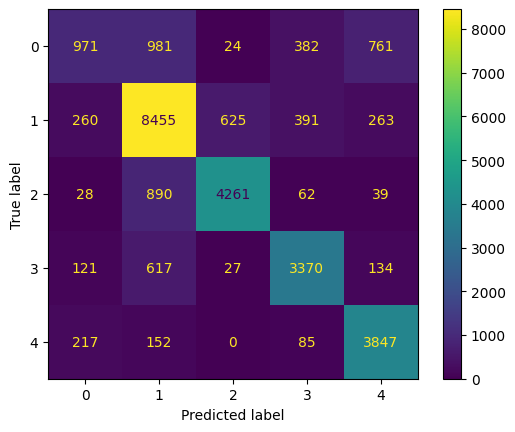

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load pre-saved data
all_wavelet_features = np.load('wavelet_features.npy')
all_labels = np.load('wavelet_labels.npy')

print("Data loaded successfully.")

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)
# Initialize and train the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Display accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
confusion_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=np.unique(all_labels)
).confusion_matrix
cv_scores_rf = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)

# Save results
np.save('accuracy.npy', np.array([accuracy]))
np.save('classification_report.npy', np.array(classification_report_dict, dtype=object))
np.save('cv_scores.npy', np.array(cv_scores_rf))
np.save('confusion_matrix.npy', confusion_matrix)

print("Model outputs saved successfully.")


c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Model training completed.


c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\sleep_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c03137

Model outputs saved successfully.


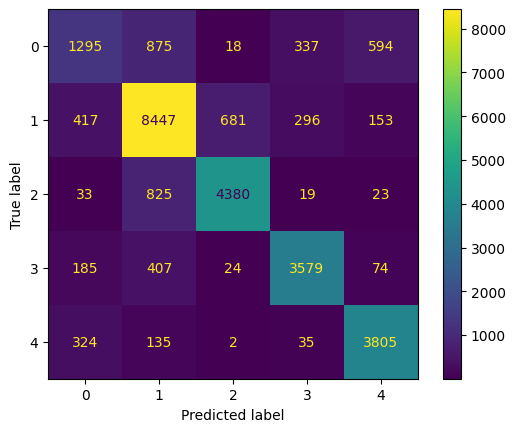

In [3]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load pre-saved data
all_wavelet_features = np.load('wavelet_features.npy')
all_labels = np.load('wavelet_labels.npy')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the XGBoost classifier
clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Compute results
accuracy = accuracy_score(y_test, y_pred)
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
confusion_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=np.unique(all_labels)
).confusion_matrix
cv_scores_xgb = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)

# Save results
np.save('xgb_accuracy.npy', np.array([accuracy]))
np.save('xgb_classification_report.npy', np.array(classification_report_dict, dtype=object))
np.save('xgb_cv_scores.npy', np.array(cv_scores_xgb))
np.save('xgb_confusion_matrix.npy', confusion_matrix)

print("Model outputs saved successfully.")


Model training completed.
Model outputs saved successfully.


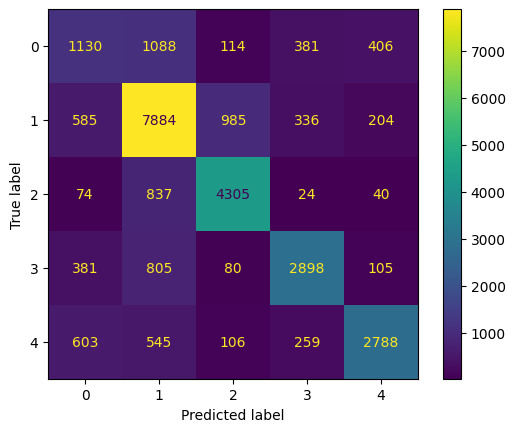

In [4]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load pre-saved data
all_wavelet_features = np.load('wavelet_features.npy')
all_labels = np.load('wavelet_labels.npy')

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(all_wavelet_features, all_labels, test_size=0.2, random_state=42)

# Initialize and train the k-NN classifier
clf = KNeighborsClassifier(n_neighbors=5)  # You can adjust n_neighbors
clf.fit(X_train, y_train)
print("Model training completed.")

# Make predictions
y_pred = clf.predict(X_test)

# Compute results
accuracy = accuracy_score(y_test, y_pred)
classification_report_dict = classification_report(y_test, y_pred, output_dict=True)
confusion_matrix = ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred, display_labels=np.unique(all_labels)
).confusion_matrix
cv_scores_knn = cross_val_score(clf, all_wavelet_features, all_labels, cv=5)

# Save results
np.save('knn_accuracy.npy', np.array([accuracy]))
np.save('knn_classification_report.npy', np.array(classification_report_dict, dtype=object))
np.save('knn_cv_scores.npy', np.array(cv_scores_knn))
np.save('knn_confusion_matrix.npy', confusion_matrix)

print("Model outputs saved successfully.")


In [5]:
from scipy import stats
mean_rf, std_rf = np.mean(cv_scores_rf), np.std(cv_scores_rf, ddof=1)
mean_xgb, std_xgb = np.mean(cv_scores_xgb), np.std(cv_scores_xgb, ddof=1)
mean_knn, std_knn = np.mean(cv_scores_knn), np.std(cv_scores_knn, ddof=1)

# Calculate Z-scores for each model pair
def z_test(mean1, std1, mean2, std2, n):
    z_score = (mean1 - mean2) / np.sqrt((std1**2 + std2**2) / n)
    p_value = stats.norm.sf(abs(z_score)) * 2  # Two-tailed test
    return z_score, p_value

n = 5  # Number of cross-validation folds

# Z-test between Random Forest and XGBoost
z_rf_xgb, p_rf_xgb = z_test(mean_rf, std_rf, mean_xgb, std_xgb, n)
print(f"Random Forest vs XGBoost: Z = {z_rf_xgb:.3f}, p = {p_rf_xgb:.3f}")

# Z-test between Random Forest and KNN
z_rf_knn, p_rf_knn = z_test(mean_rf, std_rf, mean_knn, std_knn, n)
print(f"Random Forest vs KNN: Z = {z_rf_knn:.3f}, p = {p_rf_knn:.3f}")

# Z-test between XGBoost and KNN
z_xgb_knn, p_xgb_knn = z_test(mean_xgb, std_xgb, mean_knn, std_knn, n)
print(f"XGBoost vs KNN: Z = {z_xgb_knn:.3f}, p = {p_xgb_knn:.3f}")

Random Forest vs XGBoost: Z = -4.765, p = 0.000
Random Forest vs KNN: Z = 14.116, p = 0.000
XGBoost vs KNN: Z = 22.771, p = 0.000


In [6]:
t_stat_rf_xgb, p_value_rf_xgb = stats.ttest_rel(cv_scores_rf, cv_scores_xgb)
print(f"Random Forest vs XGBoost: t = {t_stat_rf_xgb:.3f}, p = {p_value_rf_xgb:.3f}")

# Paired t-test between Random Forest and KNN
t_stat_rf_knn, p_value_rf_knn = stats.ttest_rel(cv_scores_rf, cv_scores_knn)
print(f"Random Forest vs KNN: t = {t_stat_rf_knn:.3f}, p = {p_value_rf_knn:.3f}")

# Paired t-test between XGBoost and KNN
t_stat_xgb_knn, p_value_xgb_knn = stats.ttest_rel(cv_scores_xgb, cv_scores_knn)
print(f"XGBoost vs KNN: t = {t_stat_xgb_knn:.3f}, p = {p_value_xgb_knn:.3f}")

Random Forest vs XGBoost: t = -10.920, p = 0.000
Random Forest vs KNN: t = 24.883, p = 0.000
XGBoost vs KNN: t = 60.142, p = 0.000


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

# Path to the annotation directory
annotation_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'

# Initialize a dictionary to store total durations per sleep stage
sleep_stage_durations = {}
df_stats = {}

# Iterate over each annotation file to calculate the duration per sleep stage
for i in range(10, 11):  # Adjust range based on available files
    annotation_file = os.path.join(annotation_dir, f'SN0{i}_sleepscoring.txt')
    
    # Load and process the annotation file
    annotations_df = pd.read_csv(annotation_file, header=None)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

    # Save DataFrame info, describe, and null checks
    df_stats['info'] = annotations_df.info(buf=None)
    df_stats['describe'] = annotations_df.describe().to_dict()
    df_stats['isnull'] = annotations_df.isnull().sum().to_dict()
    df_stats['shape'] = annotations_df.shape

    # Sum up durations per sleep stage
    for _, row in annotations_df.iterrows():
        stage = row["Annotation"]
        duration = row["Duration"]
        if stage not in ['Lights off', 'Lights on']:
            if stage in sleep_stage_durations:
                sleep_stage_durations[stage] += duration
            else:
                sleep_stage_durations[stage] = duration

# Convert durations to minutes (assuming they are in seconds)
sleep_stage_durations = {stage: duration / 60 for stage, duration in sleep_stage_durations.items()}

# Plotting the bar chart and saving it
plt.figure(figsize=(10, 6))
plt.bar(sleep_stage_durations.keys(), sleep_stage_durations.values(), color='skyblue')
plt.xlabel("Sleep Stage")
plt.ylabel("Total Duration (minutes)")
plt.title("Total Duration per Sleep Stage")
plt.xticks(rotation=45)
chart_path = "sleep_stage_durations_chart.npy"
plt.savefig(chart_path, format='png')
plt.close()
print(f"Chart saved at: {chart_path}")

# Save DataFrame statistics
np.save('annotations_df_stats.npy', df_stats)
print("DataFrame statistics saved.")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 927 entries, 0 to 926
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Date             927 non-null    object 
 1   Time             927 non-null    object 
 2   Recording onset  926 non-null    float64
 3   Duration         926 non-null    float64
 4   Annotation       927 non-null    object 
 5   Linked channel   927 non-null    object 
dtypes: float64(2), object(4)
memory usage: 43.6+ KB
Chart saved at: sleep_stage_durations_chart.npy
DataFrame statistics saved.


In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_wavelet_features = scaler.fit_transform(all_wavelet_features)




Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6577407  =      0.000 ... 25692.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7330815  =      0.000 ... 28635.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655487  =      0.000 ... 25997.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7944191  =      0.000 ... 31031.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6508031  =      0.000 ... 25421.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6922751  =      0.000 ... 27041.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7099647  =      0.000 ... 27732.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8763391  =      0.000 ... 34231.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7203839  =      0.000 ... 28139.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7714303  =      0.000 ... 30133.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5561087  =      0.000 ... 21722.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6663679  =      0.000 ... 26029.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8356351  =      0.000 ... 32641.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8560895  =      0.000 ... 33440.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6456575  =      0.000 ... 25220.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7283711  =      0.000 ... 28451.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7344383  =      0.000 ... 28688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7696127  =      0.000 ... 30062.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6081023  =      0.000 ... 23753.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582527  =      0.000 ... 25712.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7603455  =      0.000 ... 29700.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6781695  =      0.000 ... 26490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6702079  =      0.000 ... 26179.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927615  =      0.000 ... 27060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7308799  =      0.000 ... 28549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN030.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8111359  =      0.000 ... 31684.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5936895  =      0.000 ... 23190.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN032.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9124863  =      0.000 ... 35643.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN033.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4012543  =      0.000 ... 15673.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN034.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6815487  =      0.000 ... 26622.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN035.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649535  =      0.000 ... 29880.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN036.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6207487  =      0.000 ... 24247.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN037.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6375423  =      0.000 ... 24903.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN038.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7119615  =      0.000 ... 27810.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN039.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6819071  =      0.000 ... 26636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN040.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6153471  =      0.000 ... 24036.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN041.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6428671  =      0.000 ... 25111.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN042.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8837375  =      0.000 ... 34520.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN043.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7791615  =      0.000 ... 30435.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN044.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7461887  =      0.000 ... 29147.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN045.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5496831  =      0.000 ... 21471.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN046.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5467135  =      0.000 ... 21355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN047.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6796799  =      0.000 ... 26549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN048.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9647615  =      0.000 ... 37685.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN049.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6152447  =      0.000 ... 24032.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7161087  =      0.000 ... 27972.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN051.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7136255  =      0.000 ... 27875.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7768063  =      0.000 ... 30343.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN053.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7220223  =      0.000 ... 28203.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN054.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3831551  =      0.000 ... 14966.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7644415  =      0.000 ... 29860.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN056.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8862719  =      0.000 ... 34619.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN057.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5963263  =      0.000 ... 23293.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN058.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8056575  =      0.000 ... 31470.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN059.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6343935  =      0.000 ... 24780.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN060.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7241215  =      0.000 ... 28285.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN061.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6627327  =      0.000 ... 25887.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN062.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3610623  =      0.000 ... 14103.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN063.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9524735  =      0.000 ... 37205.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN064.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5613823  =      0.000 ... 21928.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN065.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7982847  =      0.000 ... 31182.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN066.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7761919  =      0.000 ... 30319.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN067.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7420671  =      0.000 ... 28986.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN068.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6462719  =      0.000 ... 25244.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5667583  =      0.000 ... 22138.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN070.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5162239  =      0.000 ... 20164.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN071.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8372223  =      0.000 ... 32703.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN072.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8125951  =      0.000 ... 31741.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6843135  =      0.000 ... 26730.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN074.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6490367  =      0.000 ... 25352.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN075.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8364287  =      0.000 ... 32672.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN076.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5278207  =      0.000 ... 20617.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6562559  =      0.000 ... 25634.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN078.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6714111  =      0.000 ... 26226.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN079.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8583679  =      0.000 ... 33529.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN080.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6827775  =      0.000 ... 26670.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8824063  =      0.000 ... 34468.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN082.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723135  =      0.000 ... 22355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN083.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8355071  =      0.000 ... 32636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN084.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6735103  =      0.000 ... 26308.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN085.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7728639  =      0.000 ... 30189.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN086.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5357055  =      0.000 ... 20925.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN087.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6419967  =      0.000 ... 25077.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN088.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7730431  =      0.000 ... 30196.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN089.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6193151  =      0.000 ... 24191.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN090.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6966015  =      0.000 ... 27210.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN091.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5776895  =      0.000 ... 22565.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN092.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7906559  =      0.000 ... 30884.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN093.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5975295  =      0.000 ... 23340.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN094.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8064255  =      0.000 ... 31500.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN095.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN096.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5502463  =      0.000 ... 21493.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN097.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8066047  =      0.000 ... 31507.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN098.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6720767  =      0.000 ... 26252.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN099.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6506495  =      0.000 ... 25415.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6951679  =      0.000 ... 27154.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN101.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065087  =      0.000 ... 27597.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6457087  =      0.000 ... 25222.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN103.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559423  =      0.000 ... 29528.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN104.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7739647  =      0.000 ... 30232.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN105.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6442495  =      0.000 ... 25165.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN106.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5185023  =      0.000 ... 20253.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN107.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5789439  =      0.000 ... 22614.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN108.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6774015  =      0.000 ... 26460.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN109.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6013695  =      0.000 ... 23490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7381247  =      0.000 ... 28832.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN111.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8273407  =      0.000 ... 32317.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6513407  =      0.000 ... 25442.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN113.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6854143  =      0.000 ... 26773.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN114.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4679423  =      0.000 ... 18278.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN115.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582783  =      0.000 ... 25713.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN116.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6127103  =      0.000 ... 23933.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN117.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5848319  =      0.000 ... 22844.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN118.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649791  =      0.000 ... 29881.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN119.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7038719  =      0.000 ... 27494.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN120.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6244095  =      0.000 ... 24390.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN121.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8325119  =      0.000 ... 32519.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6494463  =      0.000 ... 25368.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN123.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5757695  =      0.000 ... 22490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN124.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7960319  =      0.000 ... 31094.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9231615  =      0.000 ... 36060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN126.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6143743  =      0.000 ... 23998.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN127.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7383295  =      0.000 ... 28840.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN128.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7117823  =      0.000 ... 27803.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6637311  =      0.000 ... 25926.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN130.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3951359  =      0.000 ... 15434.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN131.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7386623  =      0.000 ... 28853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829247  =      0.000 ... 30582.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN133.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7642623  =      0.000 ... 29853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN134.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9054975  =      0.000 ... 35370.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN135.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6984959  =      0.000 ... 27284.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN136.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5350143  =      0.000 ... 20898.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN137.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8214271  =      0.000 ... 32086.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN139.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5622015  =      0.000 ... 21960.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN140.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10073343  =      0.000 ... 39348.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN141.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8182271  =      0.000 ... 31961.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN142.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6980863  =      0.000 ... 27268.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN143.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7236607  =      0.000 ... 28267.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN144.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6090751  =      0.000 ... 23791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN145.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6036223  =      0.000 ... 23578.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN146.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7849471  =      0.000 ... 30661.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948095  =      0.000 ... 27140.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN148.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655231  =      0.000 ... 25996.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN149.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6634495  =      0.000 ... 25915.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4528383  =      0.000 ... 17688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN151.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6486527  =      0.000 ... 25337.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7675135  =      0.000 ... 29980.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927871  =      0.000 ... 27061.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN154.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7708415  =      0.000 ... 30110.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_25752\3935870537.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)



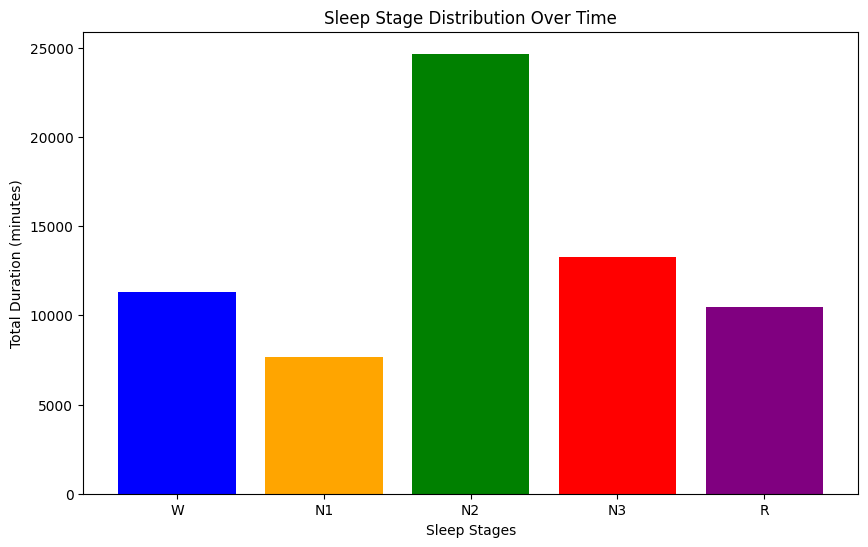

In [13]:
import os
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



# Initialize a dictionary to accumulate sleep stage durations
sleep_stage_durations = {
    "W": 0,
    "N1": 0,
    "N2": 0,
    "N3": 0,
    "R": 0
}

# Loop through files
for i in range(1, 155):  # Adjust range for files from SN001 to SN154
    if i == 138:
        continue  # Skip SN138

    # Format the index to include leading zeros
    file_index = f'{i:03}'
    edf_file = os.path.join(edf_dir, f'SN{file_index}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_index}_sleepscoring.txt')

    # Load EDF file and preprocess
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)
    raw.filter(0.5, 30, fir_design='firwin')
    raw.resample(100)

    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')

    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) & 
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150

    # Accumulate duration for each sleep stage
    for _, row in filtered_annotations_df.iterrows():
        stage = row['Annotation'].split()[-1]  # Extract the sleep stage (e.g., "W", "N1", "N2", "N3", "R")
        if stage in sleep_stage_durations:
            sleep_stage_durations[stage] += row['Duration']

# Convert accumulated durations from seconds to minutes
sleep_stage_durations = {stage: duration / 60 for stage, duration in sleep_stage_durations.items()}

# Save sleep stage durations as an .npy file
np.save("sleep_stage_durations_full.npy", sleep_stage_durations)

# Plot sleep stage distribution and save the chart as a .png file
plt.figure(figsize=(10, 6))
plt.bar(sleep_stage_durations.keys(), sleep_stage_durations.values(), color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Sleep Stages')
plt.ylabel('Total Duration (minutes)')
plt.title('Sleep Stage Distribution Over Time')
plt.savefig("sleep_stage_distribution_full.png")  # Save the chart as a PNG file
plt.show()


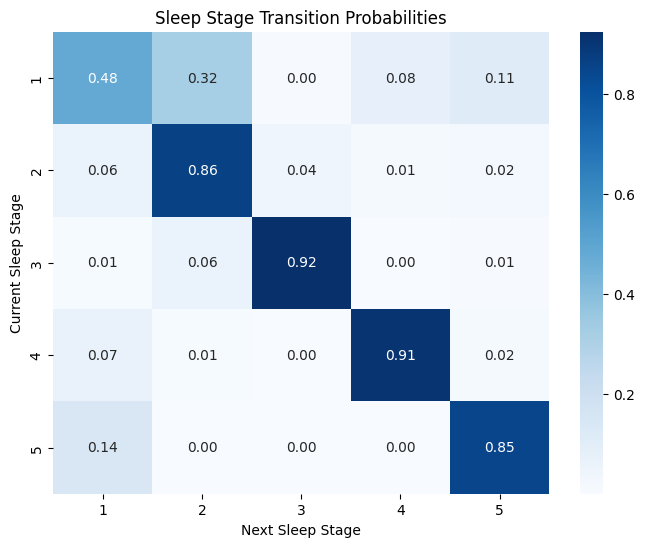

Transition matrix heatmap saved as: transition_matrix_heatmap.png


In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load all_labels from wavelet_labels.npy
all_labels = np.load('wavelet_labels.npy')

# Compute the number of unique stages
num_stages = len(np.unique(all_labels))

# Initialize the transition matrix
transition_matrix = np.zeros((num_stages, num_stages))

# Populate the transition matrix
for i in range(len(all_labels) - 1):
    current_stage = all_labels[i]
    next_stage = all_labels[i + 1]
    transition_matrix[current_stage, next_stage] += 1

# Normalize the transition matrix (optional)
row_sums = transition_matrix.sum(axis=1, keepdims=True)
transition_matrix = transition_matrix / row_sums

# Visualize the transition matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    transition_matrix, annot=True, fmt=".2f", cmap='Blues',
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.xlabel('Next Sleep Stage')
plt.ylabel('Current Sleep Stage')
plt.title('Sleep Stage Transition Probabilities')

# Save the heatmap as an image
heatmap_path = "transition_matrix_heatmap.png"
plt.savefig(heatmap_path)

# Show the heatmap
plt.show()

print(f"Transition matrix heatmap saved as: {heatmap_path}")


Degree Centrality: {0: 2.5, 1: 2.5, 2: 2.5, 3: 2.5, 4: 2.5}
Betweenness Centrality: {0: 0.0, 1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
Closeness Centrality: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}


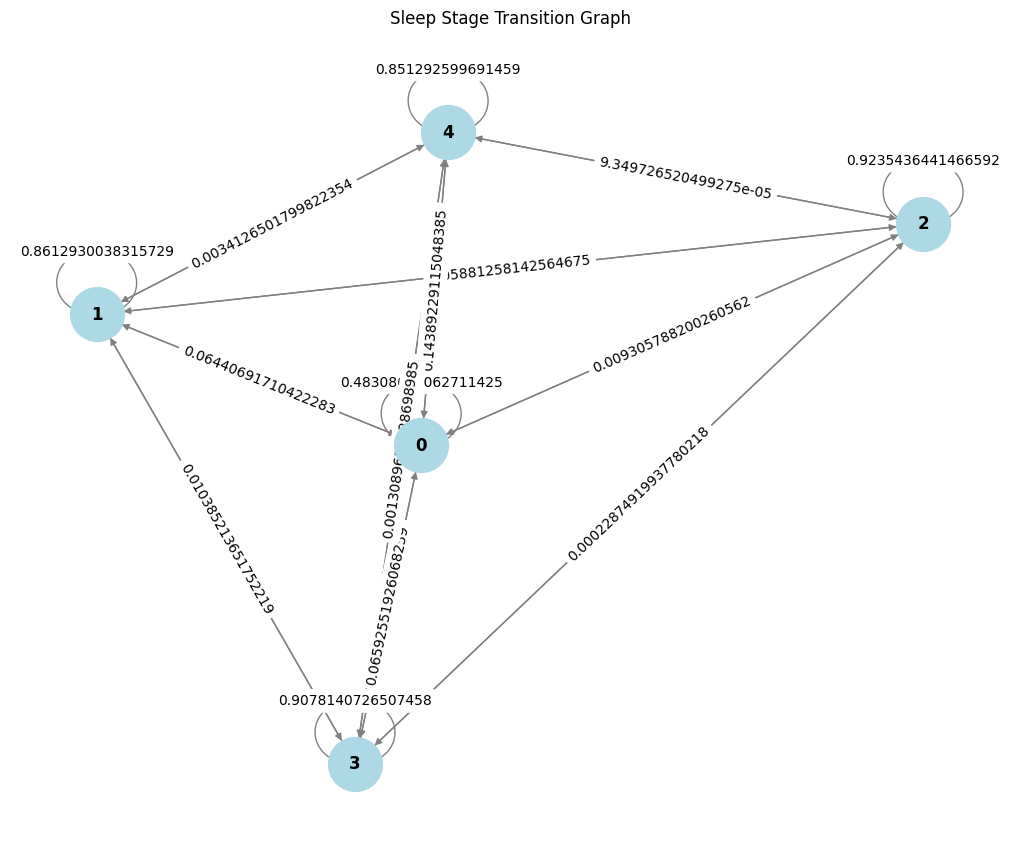

In [15]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Load the sleep stage labels
all_labels = np.load("wavelet_labels.npy")  # Corrected filename to match labels file
num_stages = len(np.unique(all_labels))

# Build the transition matrix
transition_matrix = np.zeros((num_stages, num_stages))
for i in range(len(all_labels) - 1):
    current_stage = all_labels[i]
    next_stage = all_labels[i + 1]
    transition_matrix[current_stage, next_stage] += 1

# Normalize the transition matrix
row_sums = transition_matrix.sum(axis=1)
transition_matrix = np.nan_to_num(transition_matrix / row_sums[:, np.newaxis])  # Handle zero-row cases

# Create a directed graph from the transition matrix
G = nx.DiGraph()
for i in range(num_stages):
    for j in range(num_stages):
        if transition_matrix[i, j] > 0:
            G.add_edge(i, j, weight=transition_matrix[i, j])

# Graph analysis (centrality measures)
degree_centrality = nx.degree_centrality(G)
print("Degree Centrality:", degree_centrality)

betweenness_centrality = nx.betweenness_centrality(G)
print("Betweenness Centrality:", betweenness_centrality)

closeness_centrality = nx.closeness_centrality(G)
print("Closeness Centrality:", closeness_centrality)

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)  # Generate layout positions for nodes
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color='lightblue',
    node_size=1500,
    edge_color='gray',
    font_size=12,
    font_weight='bold',
)
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title('Sleep Stage Transition Graph')
plt.savefig("sleep_stage_transition_graph.png")  # Save the graph as an image
plt.show()



In [5]:
import os
import mne
import pandas as pd
from scipy.stats import pearsonr

edf_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'
annotation_dir = r'physionet.org/files/hmc-sleep-staging/1.0.0/recordings'

# Function to calculate sleep efficiency and deep sleep percentage
def calculate_sleep_efficiency(edf_file, annotation_file):
    # Load and preprocess EDF file
    raw = mne.io.read_raw_edf(edf_file, preload=True)
    raw.crop(tmin=150, tmax=raw.times[-1] - 150)
    raw.filter(0.5, 30, fir_design='firwin')
    raw.resample(100)
    
    # Load and process annotation file
    annotations_df = pd.read_csv(annotation_file)
    annotations_df.columns = ["Date", "Time", "Recording onset", "Duration", "Annotation", "Linked channel"]
    annotations_df['Recording onset'] = pd.to_numeric(annotations_df['Recording onset'], errors='coerce')
    annotations_df['Duration'] = pd.to_numeric(annotations_df['Duration'], errors='coerce')
    
    # Filter annotations to fit within the cropped data range and adjust onset
    total_duration = raw.times[-1] - 150 * 2
    filtered_annotations_df = annotations_df[
        (annotations_df['Recording onset'] >= 150) & 
        (annotations_df['Recording onset'] <= total_duration)
    ].copy()
    filtered_annotations_df['Recording onset'] -= 150

    # Initialize sleep stage durations
    sleep_stage_durations = {"W": 0, "N1": 0, "N2": 0, "N3": 0, "R": 0}
    
    # Accumulate duration for each sleep stage
    for _, row in filtered_annotations_df.iterrows():
        stage = row['Annotation'].split()[-1]  # Extract the sleep stage (e.g., "W", "N1", "N2", "N3", "REM")
        if stage in sleep_stage_durations:
            sleep_stage_durations[stage] += row['Duration']

    # Calculate Sleep Efficiency
    total_time_in_bed = sum(sleep_stage_durations.values())  # Sum of all stage durations
    total_time_asleep = total_time_in_bed - sleep_stage_durations["W"]  # Exclude wake duration
    sleep_efficiency = (total_time_asleep / total_time_in_bed) * 100 if total_time_in_bed > 0 else 0
    
    # Calculate the percentage of time spent in deep sleep (N3)
    total_time_deep_sleep = sleep_stage_durations["N3"]
    percentage_deep_sleep = (total_time_deep_sleep / total_time_in_bed) * 100 if total_time_in_bed > 0 else 0

    return sleep_efficiency, percentage_deep_sleep

# Loop through all available files, excluding SN138
sleep_efficiencies = []
deep_sleep_percentages = []

for file_index in range(1, 155):  # Files from SN001 to SN154
    if file_index == 138:  # Skip SN138
        continue
    
    file_suffix = str(file_index).zfill(3)
    edf_file = os.path.join(edf_dir, f'SN{file_suffix}.edf')
    annotation_file = os.path.join(annotation_dir, f'SN{file_suffix}_sleepscoring.txt')

    # Check if the files exist before processing
    if os.path.exists(edf_file) and os.path.exists(annotation_file):
        try:
            sleep_efficiency, deep_sleep_percentage = calculate_sleep_efficiency(edf_file, annotation_file)
            sleep_efficiencies.append(sleep_efficiency)
            deep_sleep_percentages.append(deep_sleep_percentage)
        except Exception as e:
            print(f"Error processing {edf_file} or {annotation_file}: {e}")

# Perform Pearson's Correlation
if len(sleep_efficiencies) > 1 and len(deep_sleep_percentages) > 1:
    correlation, p_value = pearsonr(sleep_efficiencies, deep_sleep_percentages)

    # Display results
    print(f"Pearson Correlation Coefficient: {correlation:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Interpret result
    alpha = 0.05
    if p_value < alpha:
        print("There is a significant correlation: Deeper sleep corresponds to better sleep efficiency.")
    else:
        print("No significant correlation found.")
else:
    print("Insufficient data to calculate Pearson correlation.")


Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6577407  =      0.000 ... 25692.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7330815  =      0.000 ... 28635.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN004.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7804927  =      0.000 ... 30487.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655487  =      0.000 ... 25997.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN007.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7944191  =      0.000 ... 31031.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN008.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6508031  =      0.000 ... 25421.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN009.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6922751  =      0.000 ... 27041.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN010.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7099647  =      0.000 ... 27732.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN011.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8763391  =      0.000 ... 34231.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN012.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7203839  =      0.000 ... 28139.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN013.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7714303  =      0.000 ... 30133.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN014.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5561087  =      0.000 ... 21722.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN015.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6663679  =      0.000 ... 26029.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN016.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8356351  =      0.000 ... 32641.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN017.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8560895  =      0.000 ... 33440.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN018.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN019.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6456575  =      0.000 ... 25220.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN020.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7283711  =      0.000 ... 28451.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN021.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7344383  =      0.000 ... 28688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN022.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7696127  =      0.000 ... 30062.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN023.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6081023  =      0.000 ... 23753.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN024.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582527  =      0.000 ... 25712.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN025.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7603455  =      0.000 ... 29700.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN026.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6781695  =      0.000 ... 26490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN027.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6702079  =      0.000 ... 26179.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN028.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927615  =      0.000 ... 27060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN029.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7308799  =      0.000 ... 28549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN030.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8111359  =      0.000 ... 31684.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN031.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5936895  =      0.000 ... 23190.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN032.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9124863  =      0.000 ... 35643.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN033.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4012543  =      0.000 ... 15673.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN034.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6815487  =      0.000 ... 26622.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN035.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649535  =      0.000 ... 29880.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN036.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6207487  =      0.000 ... 24247.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN037.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6375423  =      0.000 ... 24903.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN038.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7119615  =      0.000 ... 27810.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN039.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6819071  =      0.000 ... 26636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN040.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6153471  =      0.000 ... 24036.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN041.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6428671  =      0.000 ... 25111.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN042.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8837375  =      0.000 ... 34520.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN043.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7791615  =      0.000 ... 30435.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN044.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7461887  =      0.000 ... 29147.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN045.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5496831  =      0.000 ... 21471.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN046.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5467135  =      0.000 ... 21355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN047.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6796799  =      0.000 ... 26549.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN048.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9647615  =      0.000 ... 37685.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN049.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6152447  =      0.000 ... 24032.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN050.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7161087  =      0.000 ... 27972.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN051.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7136255  =      0.000 ... 27875.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN052.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7768063  =      0.000 ... 30343.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN053.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7220223  =      0.000 ... 28203.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN054.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3831551  =      0.000 ... 14966.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN055.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7644415  =      0.000 ... 29860.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN056.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8862719  =      0.000 ... 34619.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN057.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5963263  =      0.000 ... 23293.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN058.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8056575  =      0.000 ... 31470.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN059.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6343935  =      0.000 ... 24780.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN060.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7241215  =      0.000 ... 28285.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN061.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6627327  =      0.000 ... 25887.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN062.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3610623  =      0.000 ... 14103.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN063.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9524735  =      0.000 ... 37205.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN064.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5613823  =      0.000 ... 21928.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN065.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7982847  =      0.000 ... 31182.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN066.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7761919  =      0.000 ... 30319.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN067.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7420671  =      0.000 ... 28986.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN068.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6462719  =      0.000 ... 25244.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN069.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5667583  =      0.000 ... 22138.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN070.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5162239  =      0.000 ... 20164.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN071.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8372223  =      0.000 ... 32703.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN072.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8125951  =      0.000 ... 31741.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN073.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6843135  =      0.000 ... 26730.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN074.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6490367  =      0.000 ... 25352.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN075.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8364287  =      0.000 ... 32672.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN076.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5278207  =      0.000 ... 20617.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN077.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6562559  =      0.000 ... 25634.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN078.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6714111  =      0.000 ... 26226.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN079.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8583679  =      0.000 ... 33529.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN080.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6827775  =      0.000 ... 26670.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN081.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8824063  =      0.000 ... 34468.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN082.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5723135  =      0.000 ... 22355.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN083.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8355071  =      0.000 ... 32636.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN084.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6735103  =      0.000 ... 26308.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN085.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7728639  =      0.000 ... 30189.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN086.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5357055  =      0.000 ... 20925.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN087.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6419967  =      0.000 ... 25077.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN088.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7730431  =      0.000 ... 30196.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN089.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6193151  =      0.000 ... 24191.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN090.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6966015  =      0.000 ... 27210.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN091.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5776895  =      0.000 ... 22565.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN092.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7906559  =      0.000 ... 30884.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN093.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5975295  =      0.000 ... 23340.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN094.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8064255  =      0.000 ... 31500.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN095.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6621439  =      0.000 ... 25864.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN096.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5502463  =      0.000 ... 21493.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN097.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8066047  =      0.000 ... 31507.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN098.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6720767  =      0.000 ... 26252.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN099.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6506495  =      0.000 ... 25415.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN100.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6951679  =      0.000 ... 27154.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN101.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7065087  =      0.000 ... 27597.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN102.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6457087  =      0.000 ... 25222.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN103.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7559423  =      0.000 ... 29528.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN104.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7739647  =      0.000 ... 30232.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN105.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6442495  =      0.000 ... 25165.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN106.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5185023  =      0.000 ... 20253.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN107.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5789439  =      0.000 ... 22614.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN108.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6774015  =      0.000 ... 26460.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN109.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6013695  =      0.000 ... 23490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN110.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7381247  =      0.000 ... 28832.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN111.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8273407  =      0.000 ... 32317.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN112.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6513407  =      0.000 ... 25442.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN113.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6854143  =      0.000 ... 26773.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN114.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4679423  =      0.000 ... 18278.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN115.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582783  =      0.000 ... 25713.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN116.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6127103  =      0.000 ... 23933.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN117.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5848319  =      0.000 ... 22844.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN118.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7649791  =      0.000 ... 29881.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN119.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7038719  =      0.000 ... 27494.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN120.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6244095  =      0.000 ... 24390.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN121.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8325119  =      0.000 ... 32519.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN122.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6494463  =      0.000 ... 25368.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN123.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5757695  =      0.000 ... 22490.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN124.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7960319  =      0.000 ... 31094.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN125.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9231615  =      0.000 ... 36060.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN126.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6143743  =      0.000 ... 23998.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN127.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7383295  =      0.000 ... 28840.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN128.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7117823  =      0.000 ... 27803.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN129.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6637311  =      0.000 ... 25926.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN130.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3951359  =      0.000 ... 15434.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN131.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7386623  =      0.000 ... 28853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN132.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7829247  =      0.000 ... 30582.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN133.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7642623  =      0.000 ... 29853.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN134.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 9054975  =      0.000 ... 35370.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN135.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6984959  =      0.000 ... 27284.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN136.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5350143  =      0.000 ... 20898.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN137.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8214271  =      0.000 ... 32086.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN139.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5622015  =      0.000 ... 21960.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN140.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 10073343  =      0.000 ... 39348.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN141.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8182271  =      0.000 ... 31961.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN142.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6980863  =      0.000 ... 27268.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN143.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7236607  =      0.000 ... 28267.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN144.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6090751  =      0.000 ... 23791.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN145.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6036223  =      0.000 ... 23578.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN146.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7849471  =      0.000 ... 30661.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN147.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6948095  =      0.000 ... 27140.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN148.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655231  =      0.000 ... 25996.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN149.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6634495  =      0.000 ... 25915.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN150.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 4528383  =      0.000 ... 17688.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN151.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6486527  =      0.000 ... 25337.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN152.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7675135  =      0.000 ... 29980.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN153.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6927871  =      0.000 ... 27061.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Extracting EDF parameters from c:\Users\lewin\OneDrive\Desktop\College Semesters\Sleep Stage Classification\physionet.org\files\hmc-sleep-staging\1.0.0\recordings\SN154.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7708415  =      0.000 ... 30110.996 secs...


C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
C:\Users\lewin\AppData\Local\Temp\ipykernel_15420\3967935428.py:12: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 1691 samples (6.605 s)

Pearson Correlation Coefficient: 0.4064
P-value: 0.0000
There is a significant correlation: Deeper sleep corresponds to better sleep efficiency.
